# Parte II: Machine Learning Baseline

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
# Do not print warings
import warnings; warnings.simplefilter('ignore')

In [3]:
RANDOM_STATE = 24 #mi numero favoritos

## Obtengo el dataset

Uno dos de los archivos con datos otorgados

In [4]:
df_identity = pd.read_csv("dataset/train_identity.csv")
df_transaction = pd.read_csv("dataset/train_transaction.csv")

In [5]:
df_train = df_identity.merge(df_transaction, on="TransactionID", how="outer")
df_identity, df_transaction = None, None #libero memoria

In [6]:
len_rows , len_columns = df_train.shape

## Identifico columas unicas

Observamos que la única columna con valores únicos es la que representa "TransactionID".

In [7]:
(df_train.nunique() == len_rows).value_counts()

False    433
True       1
dtype: int64

## Elimino columnas vacias 

Observo que no hay columnas vacias

In [8]:
(df_train.isna().sum() == len_rows).value_counts()

False    434
dtype: int64

### Identifico variables categoricas

In [9]:
df_train.dtypes[(df_train.dtypes =="object")].index

Index(['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6',
       'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6',
       'M7', 'M8', 'M9'],
      dtype='object')

## Feature engineering

### Funciones auxiliares

In [10]:
def binary_encoding(value, keys):
    if(value==keys[0]):
        return 1
    elif(value==keys[1]):
        return 0
    return np.nan

In [11]:
def mean_encoding(df, feature_name, target_name):
    values = df.groupby([feature_name])[target_name].mean().to_dict()
    return df[feature_name].map(values)

def mean_encoding_test(df, df_train, feature_name, target_name):
    values = df_train.groupby([feature_name])[target_name].mean().to_dict()
    return df[feature_name].map(values)

In [12]:
def tfidf_encoding(df, feature_name, target_name):
    return 0

### Casos particulares

In [13]:
def get_match_status(x):
    if(type(x) != float):
        return int(x.split(":")[1])
    return np.nan

def enconde_id_34(df):
    df["id_34"] = df["id_34"].apply(lambda x: get_match_status(x))

### Feature engineering

In [14]:
def feature_engineering(df_original, df_train = None, isTest=False):
    
    df = df_original.copy()
    
    # Features unicos
    features_unicas = []
    for feature in features_unicas:
        del df[feature]
    
    # Features binarios
    lista_features_binarias = [
        [["id_35", "id_36", "id_37", "id_38", 'M1', 'M2', 'M3', "M5", "M6", 'M7', 'M8', 'M9'], ["T","F"]],
        [["id_12", "id_27", "id_28", "id_29","id_16"], ["Found", "NotFound"]]
    ]
    for features_binarias, keys in lista_features_binarias:
        for feature in features_binarias:
            df[feature] = df[feature].apply(lambda x: binary_encoding(x, keys))
        
    # Features categoricos no binarios
    features_categoricas = [
        'id_15', 'id_23', 'id_30','id_31', 'id_33', 'id_34',
       'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6',
       'P_emaildomain', 'R_emaildomain', 'M4']
    for feature in features_categoricas:
        if(isTest):
            df[feature] = mean_encoding_test(df, df_train, feature, "isFraud")
        else:
            df[feature] = mean_encoding(df, feature, "isFraud")
        
    # Casos particulares
    enconde_id_34(df)
    
    return df

In [15]:
df_LR = feature_engineering(df_train).fillna(0)

## Logistic Regression

In [16]:
# Librerias

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score

In [17]:
# Se separa el target

df_LR = feature_engineering(df_train).fillna(0)

X = df_LR.drop(columns = ["isFraud"])
del X["TransactionID"]

y = df_LR["isFraud"]

df_LR = None

### Corrida básica sin tunning

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)

clf = LogisticRegression(random_state=RANDOM_STATE).fit(X_train, y_train)

roc_auc_score(clf.predict(X_test), y_test)

0.5465674443206269

### Mejor score de validación

En esta sección se calculará el mejor score de validación obtenido.

Para ello, se emplea Cross Validation y tunning de hieprparametros para obtener el mejor resultado.

In [19]:
model = LogisticRegression()

space = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}

cv = KFold(n_splits=3)

search = RandomizedSearchCV(model,
                            space,
                            cv=cv,
                            scoring='roc_auc',
                            random_state=RANDOM_STATE)

result = search.fit(X, y)

# summarize result:

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6996924441603674
Best Hyperparameters: {'solver': 'newton-cg', 'penalty': 'none', 'C': 10}


### Predicción en la compentecia

En la siguiente sección vamos a calcular la predicció si estuvieramos compitiendo con el mejor modelo que se logró con el modelo "Logistic Regression".

In [20]:
# Leo archivos test

df_identity_test = pd.read_csv("dataset/test_identity.csv")
df_transaction_test = pd.read_csv("dataset/test_transaction.csv")

df_test = df_identity_test.merge(df_transaction_test, on="TransactionID", how="outer")
df_identity_test, df_transaction_test = None, None

In [21]:
# Aplico Feature Engineering

df_test.columns = df_test.columns.str.replace("id-", "id_")
X_test = feature_engineering(df_test, df_train, True).fillna(0)
TransactionID = X_test["TransactionID"]
del X_test["TransactionID"]

In [22]:
# Creo modelo con los hiperparametros resultantes de la busqueda de hiperparametros

best_LG = LogisticRegression(
    random_state=RANDOM_STATE,
    solver = 'liblinear',
    penalty = 'l1',
    C = 0.1
)

best_LG.fit(X, y)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [23]:
# Creo archivo para realizar el submit en la competencia

result_competition = best_LG.predict_proba(X_test)
result = pd.DataFrame()

result["TransactionID"] = TransactionID
result["isFraud"] = result_competition[:, 1]

In [24]:
result.to_csv('predictions/LG-2021-11-27-11:00' + '.csv', index=False)

En la competencia se logro un puntaje de 0.837198 (private) y 0.865517 (public).

### Mejores features

In [25]:
# Creo un dataframe con la importancia de cada feature

df_features_coef = pd.DataFrame()
df_features_coef["feature"] = X_test.columns
df_features_coef["importance"] = abs(best_LG.coef_[0])
df_features_coef.set_index(["feature"], inplace=True)

In [26]:
# Busco los n features mas importantes

n = 30
top_n = df_features_coef["importance"].nlargest(n)
top_n

feature
card6            14.235052
R_emaildomain     8.078322
id_33             5.309811
DeviceInfo        4.560302
id_31             2.580144
id_30             2.196045
C3                2.019257
V153              1.398573
V65               1.331277
V241              1.320035
V240              1.242648
V48               1.094151
V50               1.000147
V111              0.954047
V174              0.947456
V252              0.868846
id_35             0.831606
V149              0.809819
V147              0.791661
V156              0.774978
V305              0.760688
V119              0.754575
V141              0.684431
V41               0.654837
V73               0.649653
V18               0.603840
id_29             0.580653
P_emaildomain     0.563317
V49               0.519384
V139              0.462967
Name: importance, dtype: float64

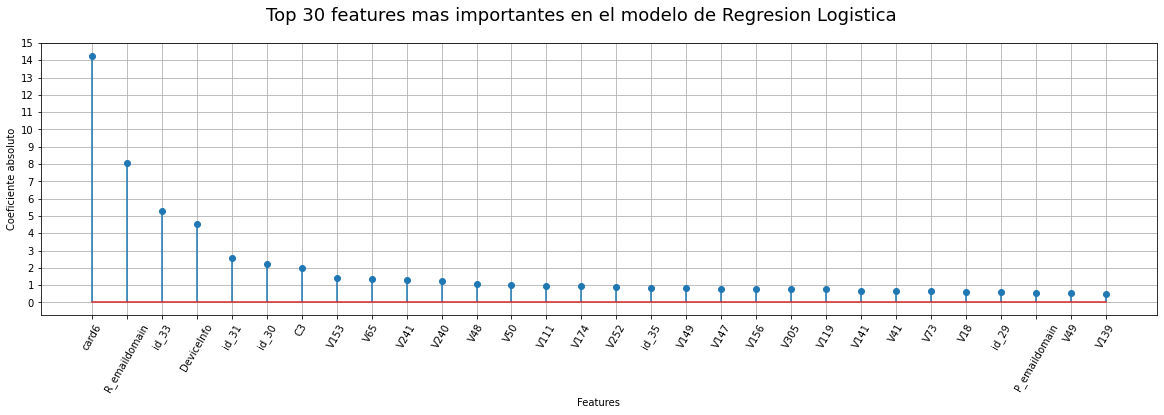

In [27]:
# Grafico los n features mas importantes

fig, axs = plt.subplots(figsize=(20,5))

plt.stem(top_n)
plt.xticks(range(n),top_n.index, rotation=60)
plt.yticks(range(16))
plt.grid(True)
plt.xlabel("Features")
plt.ylabel("Coeficiente absoluto")

fig.suptitle("Top 30 features mas importantes en el modelo de Regresion Logistica", fontsize=18)

plt.show()